# **3η Υποχρεωτική Εργασία** / *Σωτήριος-Λουκάς Καμπύλης, <u>ΑΕΜ:3805</u>*

## Γενικές Οδηγίες (*για το Dataset της MNIST*):

Για τις ανάγκες αυτής της εργασίας χρησιμοποιήθηκε το σύνηθες *Dataset* της **MNIST** με τα *χειρόγραφα ψηφία*, το οποίο φορτώθηκε από το *keras*. Οι εικόνες αποτελούνται από **784 pixels** (ή αλλιώς **28x28**). Η βάση περιέχει **60.000** εικόνες χειρόγραφων ψηφίων με σκοπό την χρήση τους στην εκπαίδευση (*train*) και **10.000** για τον έλεγχο της ποιότητας της εκπαίδευσης (*test*). Επίσης, παρέχονται και οι αντίστοιχες ετικέτες (*labels*), οι οποίες υποδεικνύουν το ψηφίο το οποίο απεικονίζεται στην εκάστοτε εικόνα. Σκοπός και κύριος στόχος της συγκεκριμένης εργασίας είναι: η υλοποίηση (*from scratch*) της μεθόδου **PCA**, η υλοποίηση (*from scratch*) και η σύγκριση της απόδοσης του *κατηγοριοποιητή πλησιέστερου γείτονα*/**KNN** (με 1 και 3 πλησιέστερους γείτονες) με τον *κατηγοριοποιητή πλησιέστερου κέντρου*/**NCC** και με το **RBF** (*Radial Basis Function*), το οποίο υλοποιείται και αυτό *from scratch*! Μάλιστα, υλοποιείται (*from scratch*) και ο αλγόριθμος των Κ-Μέσων (**K-Means**), έτσι ώστε να μπορεί να δουλέψει το **RBF**.

# 1 Εισαγωγή, Φόρτωση & Επεξεργασία των Δεδομένων

## 1.1 Εισαγωγή Απαραίτητων Βιβλιοθηκών

Παρακάτω εισάγονται οι απαραίτητες βιβλιοθήκες για να τρέξει ο υπόλοιπος κώδικας. Αυτές κρίνονται απαραίτητες για το **PCA** ή αλλιώς Principal Component Analysis, τους αλγορίθμους των 2 κατηγοριοποιητών (*κατηγοριοποιητή πλησιέστερου γείτονα με 1 και 3 πλησιέστερους γείτονες* ή αλλιώς K-Nearest Neighbors, **KNN** / *κατηγοριοποιητή πλησιέστερου κέντρου* ή αλλιώς Nearest Class Centroid Method, **NCC**) και για το **RBF** (*Radial Basis Function*). Μάλιστα, χρησιμοποιείται η **timeit** για την καταγραφή χρόνου.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import timeit

from keras.datasets import mnist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from collections import Counter


## 1.2 Φόρτωση & Επεξεργασία Δεδομένων

Αρχικά, *φορτώνουμε* το σύνολο δεδομένων της **MNIST**. Ύστερα, *κανονικοποιούμε* τις τιμές φωτεινότητας μεταξύ **0** και **1** (από **0** και **255**) έτσι ώστε να δωθεί στα δεδομένα μία κοινή κατάσταση, δηλαδή όλες οι μεταβλητές να είναι κεντραρισμένες παρόμοια. Αυτή η διαδικασία κρίνεται εξαιρετικά σημαντική για την μειώση διαστάσεων με **PCA** (η οποία θα πραγματοποιηθεί στην συνέχεια). Μάλιστα, με την `astype('float32')` μετατρέπουμε το σύνολο δεδομένων σε *32 bit πραγματικούς*, διότι έτσι θα εφαρμοστεί καλύτερα στην *RAM*! Έπειτα ο πίνακας (όπου είναι αποθηκεύμενες αυτές οι τιμές για τα train/test δεδομένα) μετατρέπεται απο *τρισδιάστατος* σε *δισδιάστατος*, κάνοντας τις διαστάσεις **28x28** (δηλαδή **784**).

In [2]:
# Φορτώνουμε το σύνολο δεδομένων της MNIST
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()


11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# Κανονικοποιούμε τα δεδομένα μεταξύ 0 και 1 (από 0 και 255)
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
train_data = train_data / 255.0
test_data = test_data / 255.0

# Μετατρέπω τα train_data/test_data από τρισδιάστατο πίνακα (60000, 28, 28) 
# σε δισδιάστατο πίνακα (60000, 784)
num_pixels = 784
train_data = train_data.reshape(train_data.shape[0], num_pixels)
test_data = test_data.reshape(test_data.shape[0], num_pixels)

# Εκτυπώνω τις τιμές έτσι ώστε να δω πως όλα πήγαν καλά!
print("Train/test data shape:", train_data.shape, test_data.shape)
print("Train/test labels shape:", train_labels.shape, test_labels.shape)


Train/test data shape: (60000, 784) (10000, 784)
Train/test labels shape: (60000,) (10000,)


Σύμφωνα με την εκφώνηση το πρόβλημα πρέπει να επιλύει ένα από τα
προβλήματα που επιλύσαμε σε μια από τις προηγούμενες εργασίες, οπότε επιλέγουμε να βασίζεται "<u>στην αναγνώριση μονών και ζυγών αριθμών στα δεκαδικά ψηφία (0,1,...,9) της MNIST</u>". Για αυτό τον λόγο μετατρέπουμε τις ετικέτες, τη **1η με labels=0**
(*για τα άρτια ψηφία*) και τη **2η με labels=1** (*για τα περιττά ψηφία*). Μάλιστα, μειώνεται το Dataset (γιατί αργούν πολύ οι κατηγοριοποιητές με όλο το Dataset, σύμφωνα με τις γνώσεις μας από την *ενδιάμεση εργασία*) στα πρώτα 4000 ψηφία του train_data και στα πρώτα 500 ψηφία του test_data!

In [4]:
# Αλλαγή του τύπου δεδομένων των ετικετών σε ακέραιους
train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)

# Αλλαγή των ετικετών για το train_data
train_labels[(train_labels%2)==0] = 0
train_labels[(train_labels%2)!=0] = 1

# Αλλαγή των ετικετών για το test_data
test_labels[(test_labels%2)==0] = 0
test_labels[(test_labels%2)!=0] = 1

# Μείωση του Dataset στα πρώτα 4000 ψηφία του train_data και στα πρώτα 500 ψηφία 
# του test_data (κυρίως γιατί όλο το Dataset είναι πολύ μεγάλο)
train_data = train_data[:4000]
test_data = test_data[:500]
train_labels = train_labels[:4000]
test_labels = test_labels[:500]

# Κανονικοποιώ με StandardScaler() έτσι ώστε να μην έχω θέμα μετά στο RBF (με φανταστικούς 
# αριθμούς) και να μπορώ να κάνω σύγκριση με τους 2 παραπάνω κατηγοριοποιητές (KNN/NCC)
train_data = StandardScaler().fit_transform(train_data)
test_data = StandardScaler().fit_transform(test_data)

# Ελέγχω την μοιρασιά (σε άρτιους και περιττούς) των 4000 πρώτων ψηφίων του μειωμένου 
# train_data
print("Αριθμός άρτιων ψηφίων του μειωμένου train_data:", len(train_data[train_labels==0]))
print("Αριθμός περιττών ψηφίων του μειωμένου train_data:", len(train_data[train_labels==1]))

# Ελέγχω την μοιρασιά (σε άρτιους και περιττούς) των 500 πρώτων ψηφίων του μειωμένου 
# test_data
print("Αριθμός άρτιων ψηφίων του μειωμένου test_data:", len(test_data[test_labels==0]))
print("Αριθμός περιττών ψηφίων του μειωμένου test_data:", len(test_data[test_labels==1]))


Αριθμός άρτιων ψηφίων του μειωμένου train_data: 1984
Αριθμός περιττών ψηφίων του μειωμένου train_data: 2016
Αριθμός άρτιων ψηφίων του μειωμένου test_data: 235
Αριθμός περιττών ψηφίων του μειωμένου test_data: 265


# 2 Ανάλυση Κύριων Συνιστωσών, **PCA** (*from sklearn* και *from scratch*)

## 2.1 Συνάρτηση PCA (*from sklearn*)

In [5]:
# Ελάχιστες Διαστάσεις για το train_data (κρατώντας το 90% της πληροφορίας)
pca = PCA(n_components=0.9)
pca_train_data = pca.fit_transform(train_data)

# Ελάχιστες Διαστάσεις για το test_data (κρατώντας το 90% της πληροφορίας)
pca = PCA(n_components=0.9)
pca_test_data = pca.fit_transform(test_data)

# Εκτυπώνω τις τιμές έτσι ώστε να δω πως όλα πήγαν καλά!
print("Ελάχιστες Διαστάσεις για το train_data (κρατώντας το 90% της πληροφορίας):", pca_train_data.shape)
print("Ελάχιστες Διαστάσεις για το test_data (κρατώντας το 90% της πληροφορίας):", pca_test_data.shape)


Ελάχιστες Διαστάσεις για το train_data (κρατώντας το 90% της πληροφορίας): (4000, 176)
Ελάχιστες Διαστάσεις για το test_data (κρατώντας το 90% της πληροφορίας): (500, 103)


Σύμφωνα με την έτοιμη συνάρτηση από την sklearn καταλαβαίνουμε πως για το *train_data* πρέπει να πάρουμε τουλάχιστον <u>176 διαστάσεις</u> και για το *test_data* πρέπει να πάρουμε τουλάχιστον <u>103 διαστάσεις</u> (**έτσι ώστε να έχουμε τουλάχιστον το 90% της πληροφορίας**). Επομένως στην υλοποίηση *from scratch* επιλέγεται το **176** ως νέος μειωμένος αριθμός διαστάσεων(για να εξυπηρετηθούν σωστά και τα δύο).

# 2.2 Συνάρτηση PCA (*from scratch*)

Παρακάτω *δημιουργούμε* την συνάρτηση για να εφαρμόσουμε μείωση διαστάσεων στις χειρόγραφες εικόνες με τη χρήση της *Μεθόδου Ανάλυσης Πρωτευουσών Συνιστωσών* (**Principal Component Analysis** ή αλλίως **PCA**). Αρχικά, αφαιρείται ο αριθμητικός μέσος όλων των γραμμών από κάθε γραμμή, έτσι ώστε να κανονικοποιήσουμε τις μεταβλητές. Έπειτα, υπολογίζουμε τον πίνακα συνδιακύμανσης (*covariance matrix*), ώστε να κατανοήσουμε πως οι μεταβλητές ποικίλουν η μία με την άλλη από τον αριθμητικό μέσο και να δούμε αν υπάρχει μεταξύ τους κάποια σχέση. Ο πίνακας αυτός είναι συμμετρικός και έχει σαν καταχωρήσεις τις συνδιακυμάνσεις που σχετίζονται με όλα τα πιθανά ζευγάρια των αρχικών μεταβλητών. Η κύρια διαγώνιος ουσιαστικά περιέχει τη διασπορά όλων των μεταβλητών και επειδή οι καταχωρήσεις είναι συμμετρικές ως προς την κύρια διαγώνιο, ο άνω και κάτω τριγωνικός πίνακας είναι ίσοι. Το πρόσημο του πίνακα μας δείχνει πως σχετίζονται οι μεταβλητές μεταξύ τους. Μετέπειτα, υπολογίζονται οι ιδιοτιμές και τα ιδιοδιανύσματα του πίνακα συνδιασποράς, ώστε να οριστούν οι κύριες συνιστώσες. Τα ιδιοδιανύσματα του πίνακα ουσιαστικά αποτελούν τις κατευθύνσεις των αξόνων όπου υπάρχει η περισσότερη διασπορά, δηλαδή η περισσότερη πληροφορία, και οι ιδιοτιμές είναι οι συντελεστές των διανυσμάτων. Οπότε, ταξινομούμε με φθίνουσα σειρά τα ιδιοδιανύσματα με βάση τις ιδιοτιμές τους και έτσι παίρνουμε τις κύριες συνιστώσες με βάση τη σημαντικότητα τους. Έτσι, απο αυτές κρατάμε όποιες επιθυμούμε απο τις πρώτες. Aυτό το βήμα αποτελεί τον υπολογισμό του feature vector (πίνακα χαρακτηριστικών). Τέλος, πρέπει να προβάλλουμε τα δεδομένα στον άξονα των κυριών συνιστωσών, πολλαπλασιάζοντας τον πίνακα των αρχικών δεδομένων με τον πίνακα χαρακτηριστικών. Όσον αφορά το y, αφαιρείται από αυτό τον αριθμητικό μέσο του x και στη συνέχεια προλλαπλασιάζουμε τον πίνακα χαρακτηριστικών με τον πίνακα του y.

In [6]:
# Συνάρτηση που πραγματοποιεί την Ανάλυση Κύριων Συνιστωσών (PCA).
# x = train_data
# y = test_data
# d = Διαστάσεις στις οποίες θα μειωθούν τα train_data & test_data
def PCA_2(x, y, d):
    # Εύρεση του αριθμητικού μέσου στον πίνακα x
    x_mean = np.mean(x, axis=0)
    # Αφαίρεση του αριθμητικού μέσου όλων των γραμμών από κάθε γραμμή (για κανονικοποίηση)
    x = x - x_mean
    # Υπολογισμός Πίνακα Συνδιακύμανσης (ΠΡΟΣΟΧΗ: Θέλει Ανάστροφο Πίνακα γιατί η 
    # συνάρτηση cov() έχει τα χαρακτηριστικά στις στήλες και τα δείγματα στις γραμμές!)
    cov = np.cov(x.T)
    # Υπολογισμός Ιδιοτιμών και Ιδιοδιανυσμάτων του Πίνακα Συνδιακύμανσης
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    # Υπολογισμός Ανάστροφων Ιδιοδιανυσμάτων (γιατί από συνάρτηση linalg.eig()
    # επιστράφηκε ως Διάνυσμα Στήλης και όχι ως Ιδιοδιάνυσμα, v[:,i])
    eigenvectors = eigenvectors.T
    # Δεικτοδότηση των ταξινόμημένων Ιδιοτιμών σε φθίνουσα σειρά
    indexes = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[indexes]
    eigenvectors = eigenvectors[indexes]
    # Υπολογισμός του νέου πίνακα x, ο οποίος κρατάει τις d πιο σημαντικές τιμές
    # του Ιδιοδιανύσματος
    new_x = eigenvectors[0:d]
    # Αφαίρεση του αριθμητικού μέσου και από τον πίνακα y
    y = y - x_mean
    # Προβολή του Ιδιοδιανύσματος μέσα στον χώρο του x (εφόσον αναστρέψουμε πάλι
    # το x!)
    pca_train = np.dot(x, new_x.T)
    # Προβολή του Ιδιοδιανύσματος μέσα στον χώρο του y (εφόσον αναστρέψουμε πάλι
    # το y!)
    pca_test = np.dot(y, new_x.T)
    return pca_train, pca_test


In [7]:
# Επιστροφή των δεδομένων μέσα από την συνάρτηση PCA (δηλαδή τις προβολές των
# Ιδιοδιανυσμάτων για το pca_train & το pca_test)
new_train_data, new_test_data = PCA_2(train_data, test_data, 176)

# Εκτυπώνω τις τιμές έτσι ώστε να δω πως όλα πήγαν καλά!
print("Ελάχιστες Διαστάσεις για το train_data (κρατώντας το 90% της πληροφορίας):", new_train_data.shape)
print("Ελάχιστες Διαστάσεις για το test_data (κρατώντας το 90% της πληροφορίας):", new_test_data.shape)


Ελάχιστες Διαστάσεις για το train_data (κρατώντας το 90% της πληροφορίας): (4000, 176)
Ελάχιστες Διαστάσεις για το test_data (κρατώντας το 90% της πληροφορίας): (500, 176)


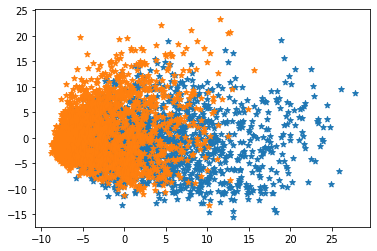

In [8]:
# Οπτικοποίηση των δεδομένων μετά από την χρήση της μεθόδου PCA
# Οι πίνακες T είναι πίνακες αληθείας που αναπαριστούν κάθε χειρόγραφο ψηφίο του Dataset
T0 = train_labels == 0
T1 = train_labels == 1

# Τοποθέτηση των γραμμών κάθε πίνακα T σε έναν άλλο πίνακα (για την επαλήθευση του Dataset
# και την οπτικοποίηση του)
M0 = new_train_data[T0 == 1, :]
M1 = new_train_data[T1 == 1, :]

# Εξαγωγή μόνο του πραγματικού μέρους του Ιδιοδιανύσματος
NM0 = M0.real
NM1 = M1.real

# Σχεδίαση των δεδομένων σε μια γραφική αναπαράσταση
plt.scatter(NM0[:, 0], NM0[:, 1], marker="*")
plt.scatter(NM1[:, 0], NM1[:, 1], marker="*")
plt.show()

Τελικά, εφαρμόζω την μέθοδο που υλοποιήθηκε *from scratch* στα παρακάτω γιατί θεωρώ πως λειτουργεί σωστά!

# 3 Χρήσιμες Μετρικές & Υλοποίηση/Σύκριση των 2 κατηγοριοποιητών.

## 3.1 Δημιουργία (*from scratch*) των 2 μετρικών που θα χρησιμοποιηθούν για την σύγκριση των 2 κατηγοριοποιητών (**KNN/NCC**) και του **RBF**.

Επιλέγονται οι: α)*Μετρική της Ευκλείδειας Απόστασης*, β)*Μετρική της Ακρίβειας* & γ)*Μετρική της Απόστασης (μέσα από Νόρμα)*!

In [9]:
# Συνάρτηση που υπολογίζει την Ευκλείδεια Απόσταση
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# Συνάρτηση που υπολογίζει την Ακρίβεια
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

# Συνάρτηση που υπολογίζει την Απόσταση (Χρησιμοποιείται στους K Μέσους/K Means)
def distance(x1, x2):
  return np.linalg.norm(x1-x2)

## 3.2 Κατηγοριοποιητής Κ Πλησιέστερων Γειτόνων (*from scratch*)

Ο Κατηγοριοποιητής Πλησιέστερων Γειτόνων είναι μία ιδιαίτερα διαδεδομένη επιβλεπόμενη μέθοδος. Αρχικά, ο αλγόριθμος δέχεται ως είσοδο τα σημεία τα οποία πρέπει να χρησιμοποιήσει για να λάβει μια μελλοντική απόφαση κατηγοριοποίησης, τις ετικέτες αυτών των σημείων, την παράμετρο Κ, καθώς και τα σημεία που καλείται να κατηγοριοποιήσει. Η παράμετρος Κ που αναφέρθηκε προηγουμένως καθορίζει το πλήθος των σημείων που εν τέλει θα επηρεάσουν την απόφαση που θα ληφθεί για ένα καινούργιο σημείο προς κατηγοριοποίηση. Η γενική ιδέα του κατηγοριοποιητή αυτού είναι η προσπάθεια να εκμεταλλευτεί την τοπικότητα η οποία χαρακτηρίζει τα δείγματα που ανήκουν στην ίδια κλάση για το εκάστοτε πρόβλημα, δηλαδή βασίζεται στο όσο πιο κοντά είναι τα σημεία θα είναι και τόσο πιο όμοια! Δεδομένου κάποιου συγκεκριμένου Κ (στην περίπτωσή μας 1 ή 3) υπολογίζονται οι αποστάσεις μεταξύ ενός δοσμένου σημείου και των σημείων του συνόλου δεδομένων, ταξινομούνται με φθίνουσα σειρά και παίρνονται οι ετικέτες των πρώτων Κ καταχωρήσεων. Τέλος, επιστρέφεται η πρόβλεψη για το σημείο αυτό. Όσον αφορά την απόσταση, χρησιμοποιείται η Ευκλείδια Απόσταση.

In [10]:
# Κλάση του Κατηγοριοποιητή Κ Πλησιέστερων Γειτόνων
class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Υπολογισμός των αποστάσεων μεταξύ των x και όλων των παραδειγμάτων στο x_train
        # μέσω της Ευκλείδειας απόστασης
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        # Ταξινόμηση μέσα από τις αποστάσεις και επιστροφή των δεικτών από τους k
        # κοντινότερους γείτονες
        k_idx = np.argsort(distances)[:self.k]
        # Εύρεση ετικετών των k κοντινότερων γειτόνων του y_train
        k_neighbor_labels = [self.y_train[i] for i in k_idx]
        # Επιστροφή της πιο κοινής ετικέτας μιας κλάσης (από τα χειρόγραφα ψηφία)
        most_common = Counter(k_neighbor_labels).most_common(1)
        return most_common[0][0]


## 3.3 Κατηγοριοποιητής Πλησιέστερου Κέντρου (**NCC** *from scratch*)

Ο Κατηγοριοποιητής Πλησιέστερου Κέντρου είναι μια μέθοδος που μοιάζει πολύ σε λογική με αυτή των Κ-μέσων. Ο αλγόριθμος δέχεται ως είσοδο τα σημεία τα οποία πρέπει να χρησιμοποιήσει για να λάβει μια μελλοντική απόφαση κατηγοριοποίησης, τις ετικέτες αυτών των σημείων, καθώς και τα σημεία που καλείται να κατηγοριοποιήσει. Η γενική ιδέα του κατηγοριοποιητή αυτού είναι η δημιουργία ενός κύκλου γύρω από κάθε κλάση ο οποίος έχει ως κέντρο του εχει το διάνυσμα με τις μέσες τιμές για κάθε χαρακτηριστικό του συνόλου των σημείων που συμμετέχουν στην κλάση αυτή, δηλαδή βασίζεται στο ότι δεδομένου ενός σημείου, του δίνει μία ετικέτα από τα δεδομένα εκπαίδευσης, ανάλογα με το ποιο κέντρο αυτών είναι κοντά του. Το κέντρο κάθε κλάσης υπολογίζεται στην εκπαίδευση. Μετά, δεδομένου ενός σημείου υπολογίζονται οι αποστάσεις από αυτό σε κάθε κέντρο κλάσης. Από όλες τις αποστάσεις επιλέγεται η μικρότερη και η ετικέτα κλάσης αυτού του κέντρου δίνεται στο σημείο.

In [11]:
# Κλάση του Κατηγοριοποιητή Πλησιέστερου Κέντρου
class NearestCentroid:
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.num_images = len(images)

    def fit(self):
        classes = np.unique(self.labels)
        self.classes = classes
        centroids = np.empty((classes.shape[0], self.images.shape[1]))
        label_to_image = []
        for cl in classes:
            img_label = []
            for j in range(0, self.num_images):
                if self.labels[j] == cl:
                    img_label.append(self.images[j])
            label_to_image.append(img_label)
        for i in range(0, len(classes)):
            centroids[i] = np.mean(label_to_image[i], axis=0)
        self.centroids = centroids

    def predict(self, images):
        classified = []
        for image in images:
            smallest_dist = 99999999
            cl = None
            for i, centroid in enumerate(self.centroids):
                dist = np.sqrt(np.sum((image - centroid) ** 2))
                if dist < smallest_dist:
                    smallest_dist = dist
                    cl = i
            classified.append([cl])
        return classified


# 4 Σύγκριση των 2 κατηγοριοποιητών (**KNN/NCC**).

Παρακάτω συγκρίνω τους 2 κατηγοριοποιητές, **KNN** & **NCC** (μετά από την μετατροπή των συνιστωσών μέσα από το **PCA** της *sklearn*)!

In [12]:
start = timeit.default_timer()
clf = KNN(k=1)
clf.fit(new_train_data, train_labels)
predictions = clf.predict(new_test_data)
print("Προβέψεις για τον KNN (με 1 γείτονα):", predictions)
# Εύρεση της Ακρίβειας (με βάση την Εκατονταβάθμια Κλίμακα)
print("Ακρίβεια για τον KNN: (με 1 γείτονα)", format(accuracy(test_labels, predictions) * 100, ".2f"), "%")
stop = timeit.default_timer()
print('Χρόνος:', stop - start, 'δευτερόλεπτα')


Προβέψεις για τον KNN (με 1 γείτονα): [1 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1
 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1
 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 0 1 1 0 0
 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 0
 0 0 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0
 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0
 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0
 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0
 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1 0 1
 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1
 1 0 1 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1
 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 0
 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0

In [13]:
start = timeit.default_timer()
clf = KNN(k=3)
clf.fit(new_train_data, train_labels)
predictions = clf.predict(new_test_data)
print("Προβέψεις για τον KNN (με 3 γείτονες):", predictions)
# Εύρεση της Ακρίβειας (με βάση την Εκατονταβάθμια Κλίμακα)
print("Ακρίβεια για τον KNN: (με 3 γείτονες)", format(accuracy(test_labels, predictions) * 100, ".2f"), "%")
stop = timeit.default_timer()
print('Χρόνος:', stop - start, 'δευτερόλεπτα')


Προβέψεις για τον KNN (με 3 γείτονες): [1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 1 0 1
 1 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1
 1 1 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 0 1 1 0 0
 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 0
 0 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0
 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1
 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 0
 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1 0 1
 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1
 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 1 1 0 1 1 0 0 0 1 0
 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 

In [14]:
start = timeit.default_timer()
clf = NearestCentroid(new_train_data, train_labels)
clf.fit()
predictions = clf.predict(new_test_data)
predictions = np.array(predictions)
predictions = predictions.flatten()
print("Προβέψεις για τον NCC:", predictions)
# Εύρεση της Ακρίβειας (με βάση την Εκατονταβάθμια Κλίμακα)
print("Ακρίβεια για τον NCC:", format(accuracy(test_labels, predictions)*100, ".2f"), "%")
stop = timeit.default_timer()
print('Χρόνος:', stop - start, 'δευτερόλεπτα')


Προβέψεις για τον NCC: [1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1
 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1
 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0
 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0
 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0
 0 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0
 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0
 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 1
 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1
 1 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 0 1 0 1
 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0
 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1
 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1
 1

<ipython-input-11-fabab186690c>:20: ComplexWarning: Casting complex values to real discards the imaginary part
  centroids[i] = np.mean(label_to_image[i], axis=0)


# 5 Νευρωνικό Δίκτυο Συνάρτησης Ακτινικής Βάσης (**RBF**) και αλγόριθμος Κ-Μέσων (**K-Means**).

Ενα σύνηθες *Νευρωνικό Δίκτυο Συνάρτησης Ακτινικής Βάσης* (ή αλλιώς **Radial Basis Function Neural Network**) αποτελείται από μία αρχιτεκτονική 3 επιπέδων νευρώνων. Στο 1ο επίπεδο βρίσκονται οι νευρώνες εισόδου, οι οποίοι
συνδέονται πλήρως με το 2o στρώμα που αποτελείται από νευρώνες με συνάρτηση ενεργοποίησης κάποια συνάρτηση ακτινικής βάσης (για αυτό και ονομάζεται έτσι το δίκτυο). Ακόμα, οι έξοδοι του μεσαίου στρώματος προωθούνται στο τελευταίο στρώμα, αυτό της εξόδου, το οποίο για προβλήματα κατηγοριοποίησης αποτελείται από **Κ νευρώνες**, όπου *Κ* ο αριθμός των πιθανών κλάσεων για ενα δείγμα. Ο βασικός στόχος του δικτύου είναι η δημιουργία συστάδων γύρω από κάποια κέντρα,  οι οποίες θα περιέχουν το σύνολο των δειγμάτων που θεωρεί το δίκτυο πως ανήκουν στην ίδια κλάση. Έτσι όταν καλείται να κατηγοριοποιήσει κάποιο νέο δείγμα υπολογίζει την απόσταση του από το κέντρο κάθε συστάδας και παράγει το ανάλογο αποτέλεσμα. Μάλιστα, για το μεσαίο στρώμα, το οποίο είναι και υπεύθυνο για την δημιουργία συστάδων και τον υπολογισμό των αποστάσεων κάθε δείγματος απο τα κέντρα τους, απαιτείται το κέντρο καθώς και η διασπορά για κάθε νευρώνα του. Για να βρεθούν τα κέντρα μπορεί να γίνει τυχαία επιλογή από τα δείγματα εκπαίδευσης ή χρήση κάποιας μεθόδου ομαδοποίησης, όπως αυτή των *Κ-Μέσων* (**K Means**). Τέλος, για την διασπορά κάθε συστάδας γίνεται χρήση της μέγιστης απόστασης ανάμεσα σε δύο διαφορετικά κέντρα από αυτά που έχουν επιλεγεί στο προηγούμενο βήμα.

Παρακάτω υλοποιείται ένα τέτοιο δίκτυο (*from scratch*):

In [15]:
# Συνάρτηση που επιλέγει τυχαία centroids για το RBF
def random(X, k):
    return X[np.random.choice(X.shape[0], k, replace=False)], [np.std(x) for x in X]

In [16]:
# Συνάρτηση που υλοποιείται ο αλγόριθμος των Κ-Μέσων/K-Means
def kmeans(X, k, max_iters=20):
    centroids = X[np.random.choice(range(len(X)), k, replace=False)]
    converged = False
    current_iter = 0
    while (not converged) and (current_iter < max_iters):
        cluster_list = [[] for i in range(len(centroids))]
        for x in X:
            distances_list = []
            for c in centroids:
                distances_list.append(distance(c, x))
            cluster_list[int(np.argmin(distances_list))].append(x)
        cluster_list = list((filter(None, cluster_list)))
        prev_centroids = centroids.copy()
        centroids = []
        for j in range(len(cluster_list)):
            centroids.append(np.mean(cluster_list[j], axis=0))
        pattern = np.abs(np.sum(prev_centroids) - np.sum(centroids))
        converged = (pattern == 0)
        current_iter += 1
    return np.array(centroids),  [np.std(x) for x in cluster_list]


In [17]:
# Κλάση που υλοποιείται ένα Νευρωνικό Δίκτυο Συνάρτησης Ακτινικής Βάσης (RBF)
class RBF:
    def __init__(self, X, y, testX, testy, classes_n, k, method=kmeans, std_from_clusters=True):
        self.X = X
        self.y = y
        self.testX = testX
        self.testy = testy
        self.classes_n = classes_n
        self.k = k
        self.method = method
        self.std_from_clusters = std_from_clusters

    def hot_encoding(self, x, classes_n):
        arr = np.zeros((len(x), classes_n))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr

    def get_rbf(self, x, c, sigma):
        distance_r = distance(x, c)
        return 1 / np.exp(-distance_r / sigma ** 2)

    def get_rbf_as_list(self, X, centroids, std_list):
        RBF_list = []
        for x in X:
            RBF_list.append([self.get_rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
        return np.array(RBF_list)

    def fit(self):
        self.centroids, self.std_list = self.method(self.X, self.k)
        if not self.std_from_clusters:
          dMax = np.max([distance(c1, c2) for c1 in self.centroids for c2 in self.centroids])
          self.std_list = np.repeat(dMax / np.sqrt(2 * self.k), self.k)
        
        # Ορίζουμε τα train RBF σε μια λίστα από centroids
        RBF_X = self.get_rbf_as_list(self.X, self.centroids, self.std_list)
        # Βρίσκουμε τα Βάρη
        self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.hot_encoding(self.y, self.classes_n)
        # Παίρνουμε τα test RBF σε μια λίστα από centroids
        RBF_list_tst = self.get_rbf_as_list(self.testX, self.centroids, self.std_list)
        # Προβλέπουμε τις ετικέτες των test RBF
        self.pred_testy = RBF_list_tst @ self.w
        # Παίρνουμε αυτό με την μεγαλύτερη πιθανότητα
        self.pred_testy = np.array([np.argmax(x) for x in self.pred_testy])
        # Βρίσκουμε την διαφορά μεταξύ των προβλέψεων και των πραγματικών ετικετών
        diff = self.pred_testy - self.testy
        print('Ακρίβεια για το RBF: ', len(np.where(diff == 0)[0]) / len(diff))


Παρακάτω θα κάνουμε κάποιες δοκιμές, οι οποίες θα αναλυθούν περισσότερο στην παρουσίαση!Περιγραφικά όμως, ρυθμίζουμε τις διάφορες παραμέτρους, δηλαδή, την μέθοδο επιλογής κέντρου (n), τον αριθμό k των clusters, τις επαναλήψεις του κ- μέσων, το αν θα έχουμε τυπική απόκλιση από τα clusters (std_from_clusters).

In [18]:
RBF_CLASSIFIER = RBF(new_train_data, train_labels, new_train_data, train_labels, classes_n=2,
                     k=10, method=random, std_from_clusters=False)

rbf_pred = RBF_CLASSIFIER.fit()

RBF_CLASSIFIER = RBF(new_test_data, test_labels, new_test_data, test_labels, classes_n=2,
                     k=10, method=random, std_from_clusters=False)

rbf_pred = RBF_CLASSIFIER.fit()

Ακρίβεια για το RBF:  0.722
Ακρίβεια για το RBF:  0.772


In [19]:
RBF_CLASSIFIER = RBF(new_train_data, train_labels, new_train_data, train_labels, classes_n=2,
                     k=15, method=random, std_from_clusters=False)

rbf_pred = RBF_CLASSIFIER.fit()

RBF_CLASSIFIER = RBF(new_test_data, test_labels, new_test_data, test_labels, classes_n=2,
                     k=15, method=random, std_from_clusters=False)

rbf_pred = RBF_CLASSIFIER.fit()

Ακρίβεια για το RBF:  0.81275
Ακρίβεια για το RBF:  0.784


In [20]:
RBF_CLASSIFIER = RBF(new_train_data, train_labels, new_train_data, train_labels, classes_n=2,
                     k=25, method=random, std_from_clusters=False)

rbf_pred = RBF_CLASSIFIER.fit()

RBF_CLASSIFIER = RBF(new_test_data, test_labels, new_test_data, test_labels, classes_n=2,
                     k=25, method=random, std_from_clusters=False)

rbf_pred = RBF_CLASSIFIER.fit()

Ακρίβεια για το RBF:  0.813
Ακρίβεια για το RBF:  0.87


In [21]:
RBF_CLASSIFIER = RBF(new_train_data, train_labels, new_train_data, train_labels, classes_n=2,
                     k=35, method=random, std_from_clusters=False)

rbf_pred = RBF_CLASSIFIER.fit()

RBF_CLASSIFIER = RBF(new_test_data, test_labels, new_test_data, test_labels, classes_n=2,
                     k=35, method=random, std_from_clusters=False)

rbf_pred = RBF_CLASSIFIER.fit()

Ακρίβεια για το RBF:  0.84475
Ακρίβεια για το RBF:  0.876


Παρατηρούμε ότι όσο ανεβάζουμε τον αριθμό των clusters, τόσο ανεβαίνει και η ακρίβεια του δικτύου μας. Ας δοκιμάσουμε να αλλάξουμε το std_from_clusters:

In [22]:
RBF_CLASSIFIER = RBF(new_train_data, train_labels, new_train_data, train_labels, classes_n=2,
                     k=35, method=random, std_from_clusters=True)

rbf_pred = RBF_CLASSIFIER.fit()

RBF_CLASSIFIER = RBF(new_test_data, test_labels, new_test_data, test_labels, classes_n=2,
                     k=35, method=random, std_from_clusters=True)

rbf_pred = RBF_CLASSIFIER.fit()

Ακρίβεια για το RBF:  0.5025
Ακρίβεια για το RBF:  0.586


Παρατηρούμε ότι η τυπική απόκλιση από τους clusters **μείωσε** την ακρίβεια του δικτύου μας, κάτι το οποίο είναι και λογικό.